In [596]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
import plotly.express as px
from pypfopt import EfficientFrontier
#conda install -c plotly chart-studio
from chart_studio import plotly
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from sympy import symbols, solve
from plotly.subplots import make_subplots
import math as mh

In [597]:
from log_return import log_returns
from covariance import cov_matrix
from mean_ret import mean_return
from rolling_cov_re import rolling_er_cov

# Importing data

In [598]:
df_data = pd.read_excel('Dat.xlsx', header=[0,1], index_col=0)

### Example usage of stocks

In [708]:
stocks = df_data['Last Price'].iloc[5:10,4:]
stocks

2010-12-31  2011-12-30  2012-12-31  2013-12-31  2014-12-31  \
MAERSKB   1573.08887  1157.34675  1321.70687  1905.90254  1767.69623   
MCD         76.76000   100.33000    88.21000    97.03000    93.70000   
BA          65.26000    73.35000    75.36000   136.49000   129.98000   
KO          32.88500    34.98500    36.25000    41.31000    42.22000   
NKE         21.35500    24.09250    25.80000    39.32000    48.07500   

          2015-12-31  2016-12-30  2017-12-29  2018-12-31  2019-12-31  \
MAERSKB   1148.66194  1399.27627  1532.24543  1097.52898  1442.01474   
MCD        118.14000   121.72000   172.12000   177.57000   197.61000   
BA         144.59000   155.68000   294.91000   322.50000   325.76000   
KO          42.96000    41.46000    45.88000    47.35000    55.35000   
NKE         62.50000    50.83000    62.55000    74.14000   101.31000   

          2020-12-31  2021-12-31  2022-12-30  
MAERSKB   2245.62273  3568.22228  2249.87757  
MCD        214.58000   268.07000   263.53000  
BA         214.06000   201.32000   190.49000  
KO          54.84000    59.21000    63.61000  
NKE        141.47000   166.67000   117.01000

## Calculating log returns

In [709]:
log_re = log_returns(stocks).replace([np.inf, -np.inf], np.nan).dropna(axis=1)
log_re

2011-12-30  2012-12-31  2013-12-31  2014-12-31  2015-12-31  \
MAERSKB    -0.306911    0.132794    0.366032   -0.075279   -0.431079   
MCD         0.267781   -0.128744    0.095300   -0.034922    0.231772   
BA          0.116863    0.027034    0.593975   -0.048871    0.106522   
KO          0.061903    0.035520    0.130665    0.021789    0.017375   
NKE         0.120615    0.068474    0.421359    0.201029    0.262404   

          2016-12-30  2017-12-29  2018-12-31  2019-12-31  2020-12-31  \
MAERSKB     0.197357    0.090779   -0.333673    0.272980    0.442942   
MCD         0.029853    0.346469    0.031173    0.106930    0.082387   
BA          0.073900    0.638868    0.089433    0.010058   -0.419905   
KO         -0.035540    0.101300    0.031538    0.156110   -0.009257   
NKE        -0.206680    0.207480    0.169989    0.312230    0.333903   

          2021-12-31  2022-12-30  
MAERSKB     0.463085   -0.461192  
MCD         0.222566   -0.017081  
BA         -0.061361   -0.055296  
KO          0.076671    0.071680  
NKE         0.163928   -0.353756

### Labels for later

In [710]:
labels = log_re.index
labels

Index(['MAERSKB ', 'MCD ', 'BA ', 'KO ', 'NKE '], dtype='object')

# Calculating Covariance matrix

In [711]:
cov_var = cov_matrix(log_re.T)
cov_var

MAERSKB       MCD        BA        KO       NKE 
MAERSKB   0.116638  0.000464 -0.002952  0.003397  0.030986
MCD       0.000464  0.019588  0.016438  0.002427  0.010639
BA       -0.002952  0.016438  0.080923  0.008127  0.012493
KO        0.003397  0.002427  0.008127  0.003151  0.004269
NKE       0.030986  0.010639  0.012493  0.004269  0.049145

## Inverse covariance matrix

In [712]:
inv_cov = np.linalg.inv(cov_var)

# Mean return of each stock

In [713]:
mean_re = mean_return(log_re.T)
mean_re

array([0.02981956, 0.1027903 , 0.08926837, 0.05497951, 0.14174779])

In [714]:
n = log_re.to_numpy().shape[0]
n

5

In [715]:
def exp_return(w, R):
  emp_list = []
  for x in w:
    emp_list.append(x@R)
  return np.array(emp_list)

In [716]:
def vol_portfolio(weights,covar_matrix):
  empty_list = []
  for i in [weights]:
    # We use the variance of a portfolio formula:
    empty_list.append(i@covar_matrix@i)
  return np.array(empty_list)

# Effecient frontier using two-fund theorem

In [733]:
vector_ones = np.ones(len(labels))

# Finding MVP 

### Calculate z vector

In [718]:
z = inv_cov @ vector_ones
z

array([-2.55308739e-01,  3.69919309e+01, -3.23370325e+01,  3.90407479e+02,
       -1.31947970e+01])

### Normalize weights

In [719]:
mvp_weight = []
for i in range(0,len(z)):
    mvp_weight.append(z[i] / sum(z))


### Weights of the minimum variance portfolio

In [720]:
mvp_weight

[-0.000669026541446064,
 0.09693590491665051,
 -0.08473792617948273,
 1.0230474961077676,
 -0.034576448303489236]

### Return and volatility of MVP

#### Return

In [721]:
mvp_return = mvp_weight@mean_re
mvp_return

0.05372521396243635

#### Volatiliy

In [722]:
mvp_var = mvp_weight@cov_var@mvp_weight
mvp_vol = np.sqrt(mvp_var)
mvp_vol

0.05119043661075545

# Finding SR

In [723]:
r_f = 0.002

In [724]:
z_SR = inv_cov @ (mean_re - r_f * 1)
z_SR

array([-0.68996323,  3.63529077, -1.61041554, 16.97798064,  1.42608378])

### Normalize weights

In [725]:
sr_weight = []
for i in range(0,len(z_SR)):
    sr_weight.append(z_SR[i] / sum(z_SR))

### Weights of SR

In [726]:
sr_weight

[-0.03495435685408883,
 0.1841681500668717,
 -0.08158556457470448,
 0.8601246727967252,
 0.07224709856519636]

## Return and volatility of SR

In [727]:
sr_return = sr_weight@mean_re
sr_return

0.06813546061779138

In [728]:
sr_var = sr_weight@cov_var@sr_weight
sr_vol = np.sqrt(sr_var)
sr_vol

0.05788351249310359

## Creating two optimal portfolio weights

In [729]:
# First we create a vector of 1 with a lenght equal to the quantity of stocks:
vector_ones = np.ones(len(labels))
# Now we calculate a vector (@ is the dot multiplication)
a = vector_ones@inv_cov@mean_re
# Now we calculate b: 
b = mean_re.T@inv_cov@mean_re
# c vector:
c = vector_ones.T@inv_cov@vector_ones
# Then d:
d = b*c-a**2


g = 1/d*(b*inv_cov@vector_ones - a*inv_cov@mean_re)
h = 1/d*(c*inv_cov@mean_re - a*inv_cov@vector_ones)
# Optimal Weights for minimal variance expecting a 25% return, shortselling is allowed
weight1 = g + h*0.22
# Optimal weights for minimal variance expecting a 28% return, shortselling is allowed
weight2 = g + h*0.28


In [730]:
def alpha(emp):
    for i in range(1000):
        #emp.append(round(emp[i]+ 0.002, 3))
        emp.append(emp[i]+ 1/100)
    return emp
    # Let's calculate a list with values between -5 and 5:
alpha = alpha([-5])


def w3(weight1,weight2,alpha):
  weight3 = []
  for i in alpha:
    weight3.append(i*weight1 + (1-i)*weight2)
  return np.array(weight3)
# Now we have obtained the entire efficient frontier just from the two original optimal solutions:
weight3 = w3(weight1,weight2,alpha)


def exp_return(w, R):
  emp_list = []
  for x in w:
    emp_list.append(x@R.T)
  return np.array(emp_list)

r = exp_return(weight3,mean_re)
    
def vol_portfolio(weights,covar_matrix):
  empty_list = []
  for i in weights:
    # We use the variance of a portfolio formula:
    empty_list.append(i@covar_matrix@i.T)
  return np.array(empty_list)

vol_port = vol_portfolio(weight3,cov_var)


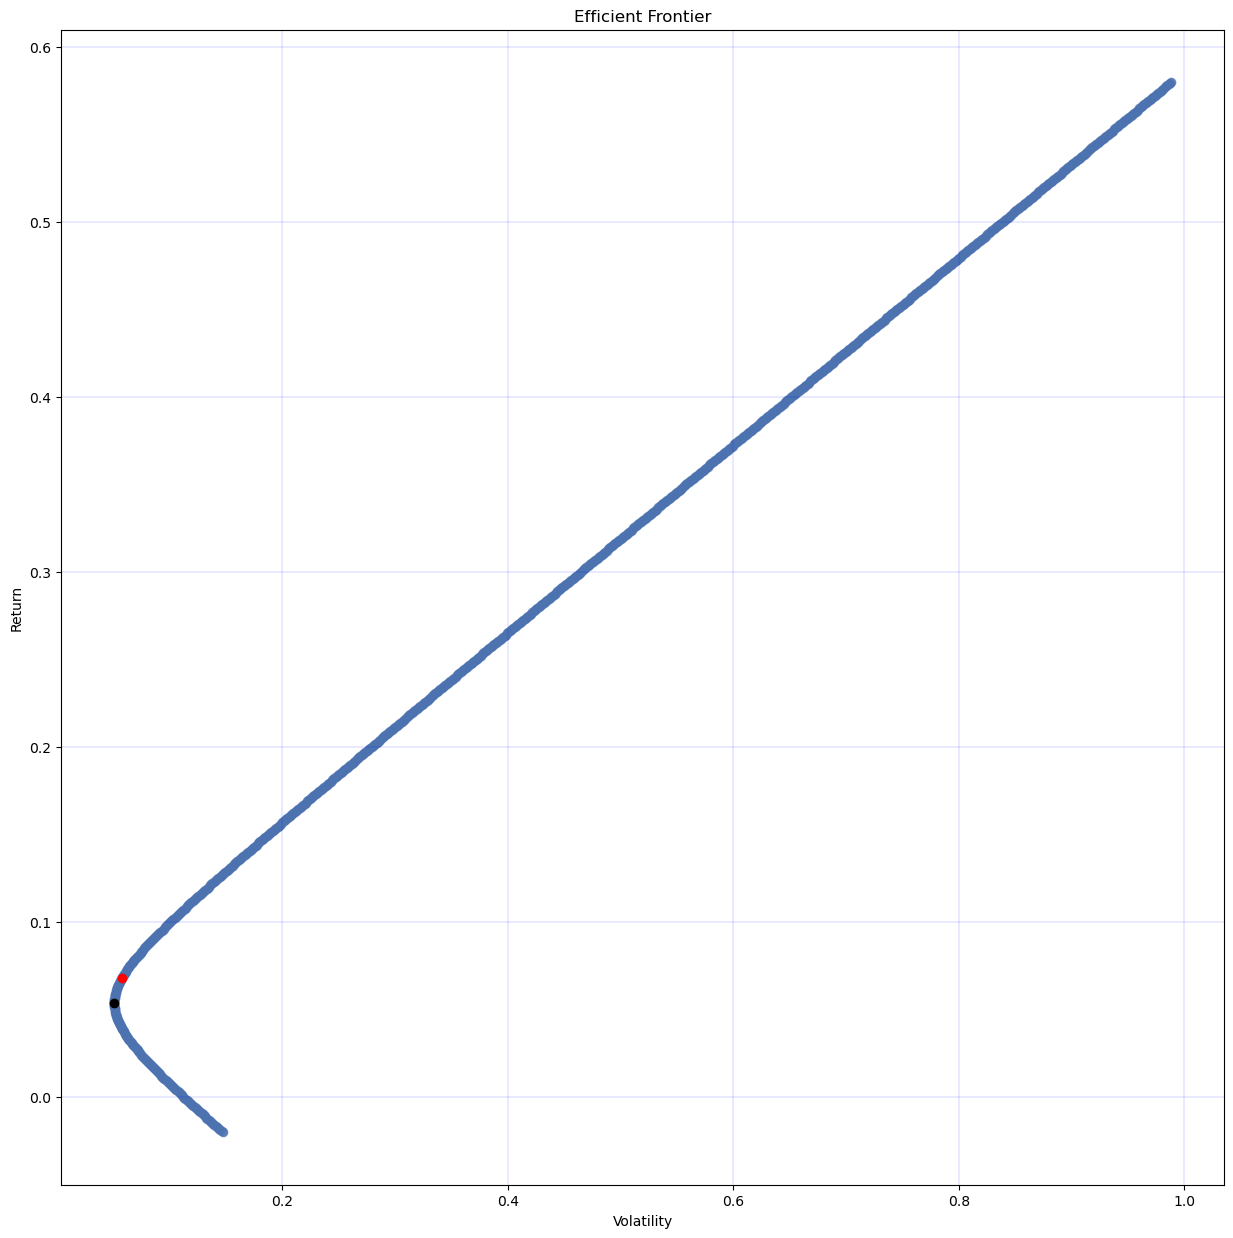

In [731]:
volatility = np.sqrt(vol_port)
expected_ret = r
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(volatility, expected_ret, alpha=0.70)
ax.scatter(mvp_vol, mvp_return, c='black')
ax.scatter(sr_vol, sr_return, c='red')
ax.set_title('Efficient Frontier')
ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.grid(color='blue', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [400]:
#Helper function to finde various performance measures for the portfolio
def portfolio_performance(return_mean,cov_matrix,num_portfolios,riskfree_rate=0):
    
    #Defining lists that are used later for calculations
    weight = np.zeros((num_portfolios,n))
    expectedReturn = np.zeros(num_portfolios)
    expectedVolatility = np.zeros(num_portfolios)
    SharpeRatio = np.zeros(num_portfolios)
    tickers_list = []
    mean_variance_pairs = []
    alpha_list = np.zeros(num_portfolios)
    
    
    #We use a minimizer so we create a helper function find the negative sharpe ratio, which will be the highest
    def negativeSR(w):
        w = np.array(w)
        #Calculating volatility with help from numpy square root function
        V = np.sqrt(w.T @ cov_matrix @ w)
        #Calculating the expected return of our portfolio. Summing over each mean return for a stock multiplied by a weight - Making use of the numpy sum function
        R = np.sum(return_mean * w)
        SR = R/V
        return -1*SR

    #Helper function used as a constraint
    def checkSumToOne(w):
        return np.sum(w)-1

    #Function to calculate volatility, and to later minimize the volatility for a given target return
    def Volatility(w):
        w = np.array(w)
        V = (w @ cov_matrix @ w.T)
        return V

    #Function to calculate the expected return of a portfolio given certain weights
    def getReturn(w):
        w = np.array(w)
        R = np.sum(return_mean @  w.T)
        return R 
    

    def alpha(emp):
        for i in range(1000):
            emp.append(round(emp[i]+ 0.002, 3))
        return emp
    # Let's calculate a list with values between -5 and 5:
    alpha = alpha([-1])
    print(alpha)

    #Looping through each portfolio
    for k in range(num_portfolios):
        #next_i = False
        #while True:

            assets = np.random.choice(list(labels), len(labels), replace=False)
            # generate random weight vector
            w = np.array(np.random.random(n))
        
            #Normalize it
            w = w / np.sum(w)
        
            #Put the weight into the list
            weight[k,:] = w
            
            #Expected return in %
            expectedReturn[k] = np.sum(return_mean * w)
        
            #Expected volatility
            expectedVolatility[k] = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        
            # Sharpe ratio
            SharpeRatio[k] = (expectedReturn[k]-riskfree_rate) / expectedVolatility[k]  

            
            #-- Skip over dominated portfolios
            #for R,V in mean_variance_pairs:
                #for k in range(num_portfolios):
                    #if (R > expectedReturn[k]) & (V < expectedVolatility[k]):
                        #next_i = True
                        #break
                #if next_i:
                    #break
            
            #mean_variance_pairs.append([expectedReturn, expectedVolatility])
            tickers_list.append(assets)  

    #Create the initial guess
    w0 = n*[1./n]  
    

    #Create the constraints, that the portfolio weights has to be between 0 and 1
    constraintSet = (0,1)
    bounds = tuple(constraintSet for asset in range(n))

    #Find the optimal point with the highest sharpe ratio
    constraints = ({'type':'eq', 'fun':checkSumToOne})
    w_opt = minimize(negativeSR, w0, method='SLSQP', bounds=bounds, constraints=constraints).x
    sharpe_exp = getReturn(w_opt)
    sharpe_vol = Volatility(w_opt)
    #w1 = w_opt*0.28 
    #w2 = w_opt 

    #Find the point for the minimum variance portfolio
    w_min = minimize(Volatility, w0, method='SLSQP', bounds=bounds, constraints=constraints).x
    mvp_exp = getReturn(w_min)
    mvp_vol = Volatility(w_min)
    w1 = w_min*mvp_exp
    w2 = w_min*sharpe_exp
    
    #Empty list for optimal volatility weights
    volatility_opt = []
    
    def w3(weight1,weight2,alpha):
            weight3 = []
            for i in alpha:
                weight3.append(i*weight1 + (1-i)*weight2)
            return np.array(weight3)
        
    # Now we have obtained the entire efficient frontier just from the two original optimal solutions:
    weight3 = w3(w1, w2, alpha)
    
    def newReturn(w, R):
        emp_list = []
        for x in w:
            emp_list.append(x@R.T)
        return np.array(emp_list)
    
    
    def var_portfolio(weights,covar_matrix):
        empty_list = []
        for i in weights:
            # We use the variance of a portfolio formula:
            empty_list.append(i@covar_matrix@i.T)
        return np.array(empty_list)

    var_port = var_portfolio(weight3, cov_matrix)


    ef_re = newReturn(weight3, return_mean)

    #Now we can calculate the Share Ratio and minimum variance portfolio

    
    return expectedReturn, expectedVolatility, SharpeRatio, volatility_opt, (sharpe_exp,sharpe_vol,(sharpe_exp-riskfree_rate) / sharpe_vol), w_opt, mvp_exp, mvp_vol, weight, tickers_list, ef_re, var_port, weight3, w1, w2

In [401]:
num_portfolios = 3000
expectedReturn, expectedVolatility, SharpeRatio, volatility_opt, sharpepoint, weightlist, mvp_exr, mvp_std, w, ticker, ef_re_t, ef_var, weight3, w1, w2 = portfolio_performance(mean_re,cov_var.to_numpy(),num_portfolios,riskfree_rate=0)

[-1, -0.998, -0.996, -0.994, -0.992, -0.99, -0.988, -0.986, -0.984, -0.982, -0.98, -0.978, -0.976, -0.974, -0.972, -0.97, -0.968, -0.966, -0.964, -0.962, -0.96, -0.958, -0.956, -0.954, -0.952, -0.95, -0.948, -0.946, -0.944, -0.942, -0.94, -0.938, -0.936, -0.934, -0.932, -0.93, -0.928, -0.926, -0.924, -0.922, -0.92, -0.918, -0.916, -0.914, -0.912, -0.91, -0.908, -0.906, -0.904, -0.902, -0.9, -0.898, -0.896, -0.894, -0.892, -0.89, -0.888, -0.886, -0.884, -0.882, -0.88, -0.878, -0.876, -0.874, -0.872, -0.87, -0.868, -0.866, -0.864, -0.862, -0.86, -0.858, -0.856, -0.854, -0.852, -0.85, -0.848, -0.846, -0.844, -0.842, -0.84, -0.838, -0.836, -0.834, -0.832, -0.83, -0.828, -0.826, -0.824, -0.822, -0.82, -0.818, -0.816, -0.814, -0.812, -0.81, -0.808, -0.806, -0.804, -0.802, -0.8, -0.798, -0.796, -0.794, -0.792, -0.79, -0.788, -0.786, -0.784, -0.782, -0.78, -0.778, -0.776, -0.774, -0.772, -0.77, -0.768, -0.766, -0.764, -0.762, -0.76, -0.758, -0.756, -0.754, -0.752, -0.75, -0.748, -0.746, -0.744

In [402]:
weight3

array([[4.49613076e-18, 3.77011280e-02, 0.00000000e+00, 0.00000000e+00,
        7.22817364e-03, 1.32656507e-01],
       [4.49398560e-18, 3.76831403e-02, 0.00000000e+00, 0.00000000e+00,
        7.22472499e-03, 1.32593215e-01],
       [4.49184044e-18, 3.76651526e-02, 0.00000000e+00, 0.00000000e+00,
        7.22127634e-03, 1.32529923e-01],
       ...,
       [2.35526297e-18, 1.97494414e-02, 0.00000000e+00, 0.00000000e+00,
        3.78642229e-03, 6.94910747e-02],
       [2.35311782e-18, 1.97314537e-02, 0.00000000e+00, 0.00000000e+00,
        3.78297364e-03, 6.94277827e-02],
       [2.35097266e-18, 1.97134660e-02, 0.00000000e+00, 0.00000000e+00,
        3.77952500e-03, 6.93644907e-02]])

In [403]:
sum(weight3[0])+sum(weight3[1])+sum(weight3[2])

0.5325032400232456

# The plot

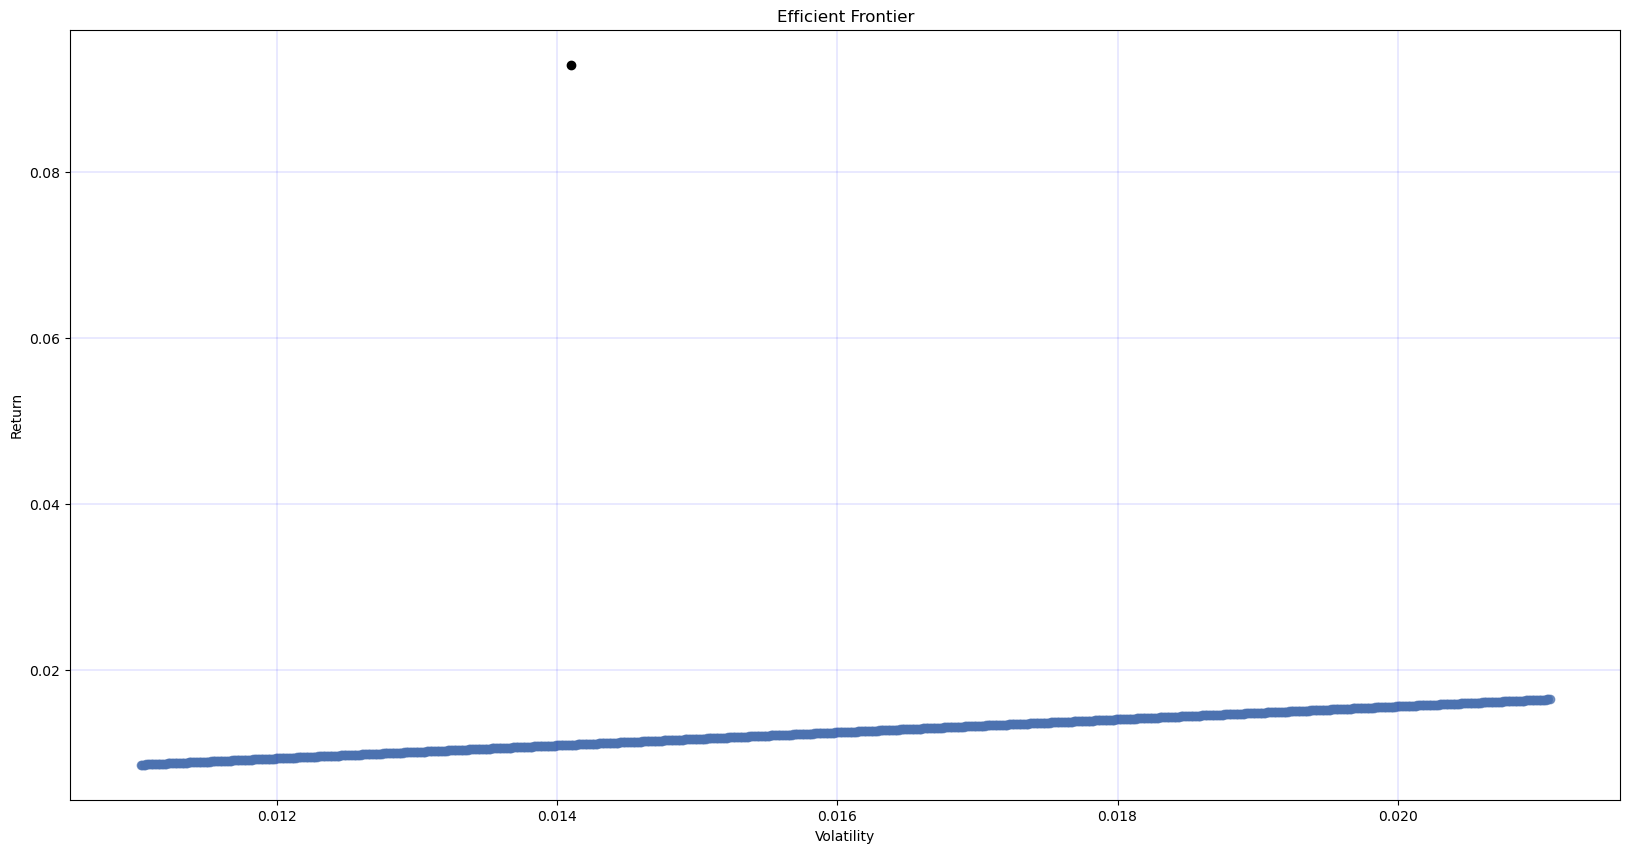

In [404]:
x = np.sqrt(ef_var)
y = ef_re_t
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x, y, alpha=0.70)
ax.scatter(mvp_std, mvp_exr, c='black')
ax.set_title('Efficient Frontier')
ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.grid(color='blue', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()
